# Sampling from a GP

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra

### Loading the banana dataset from OpenML

In [2]:
kernel = SqExponentialKernel()
x = range(0, 10, length=50)
K = kernelmatrix(kernel, x)
f = rand(MvNormal(K + 1e-8I)) # Sample a random GP
y = rand.(Bernoulli.(AGP.logistic.(f)))
y_sign = sign.(y .- 0.5)

50-element Vector{Float64}:
 -1.0
  1.0
  1.0
 -1.0
  1.0
 -1.0
  1.0
 -1.0
 -1.0
 -1.0
  ⋮
  1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
  1.0
  1.0

### We create a function to visualize the data

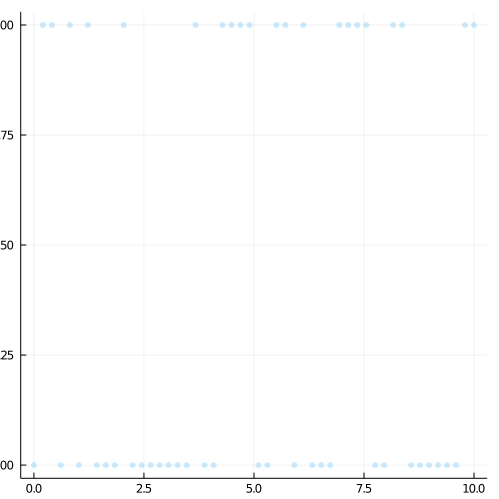

In [3]:
function plot_data(x, y; size=(300,500))
    Plots.scatter(x,
                y,
                alpha=0.2,
                markerstrokewidth=0.0,
                lab="",
                size=size
            )
end
plot_data(x, y; size = (500, 500))

### Run the variational gaussian process approximation

In [4]:
@info "Running full model"
mfull = VGP(x, y_sign,
            kernel,
            LogisticLikelihood(),
            AnalyticVI(),
            optimiser = false
            )
@time train!(mfull, 5)

[ Info: Running full model
  0.656084 seconds (1.15 M allocations: 67.520 MiB, 99.37% compilation time)


### We can also create a sampling based model

In [5]:
@info "Sampling from model"
mmcmc = MCGP(x, y,
            kernel,
            LogisticLikelihood(),
            GibbsSampling(),
            optimiser = false
            )
m = mmcmc
@time samples = sample(mmcmc, 1000)

[ Info: Sampling from model
Sampling with Gibbs Sampler   0%|                       |  ETA: N/A
Sampling with Gibbs Sampler   0%|▏                      |  ETA: 0:05:39
Sampling with Gibbs Sampler   1%|▎                      |  ETA: 0:02:52
Sampling with Gibbs Sampler   1%|▍                      |  ETA: 0:01:55
Sampling with Gibbs Sampler   2%|▍                      |  ETA: 0:01:26
Sampling with Gibbs Sampler   2%|▌                      |  ETA: 0:01:08
Sampling with Gibbs Sampler   3%|▋                      |  ETA: 0:00:57
Sampling with Gibbs Sampler   3%|▊                      |  ETA: 0:00:48
Sampling with Gibbs Sampler   4%|▉                      |  ETA: 0:00:42
Sampling with Gibbs Sampler   4%|█                      |  ETA: 0:00:37
Sampling with Gibbs Sampler   5%|█                      |  ETA: 0:00:34
Sampling with Gibbs Sampler   5%|█▏                     |  ETA: 0:00:30
Sampling with Gibbs Sampler   5%|█▎                     |  ETA: 0:00:28
Sampling with Gibbs Sampler   6%|█▍     

1000-element Vector{Vector{Vector{Float64}}}:
 [[-0.6311085500539895, -0.7509349634627406, -0.7576264834899715, -0.7284637633628653, -0.6356376375702052, -0.5635975237090463, -0.501728838122725, -0.5219227277614135, -0.5144945764256457, -0.5893527497861365  …  -0.6825697468118708, -0.9779801206050036, -1.2445913131069233, -1.394425844609703, -1.448217782306553, -1.3223127523026177, -1.1480055936826132, -0.8578668077304673, -0.5839721723053221, -0.3168351887821107]]
 [[1.0296861195095393, 1.4468048760560268, 1.7511819590501774, 1.8957637504555456, 1.7937132334357495, 1.5009532528221992, 1.0130007186271066, 0.39381092712955096, -0.23812037005778686, -0.8546671567293491  …  -0.4205619407809756, -0.6869403818230294, -0.9696564635329157, -1.2116724935869176, -1.3566064137443015, -1.3323045968240586, -1.188838052674725, -0.918670256629053, -0.5482496954083739, -0.12218054954379204]]
 [[-0.474247372307442, -0.3520909388811339, -0.26512123191542514, -0.21746675707036, -0.19770638900713405, -0.

### We can now visualize the results of both models

### We first plot the latent function f (truth, the VI estimate, the samples)

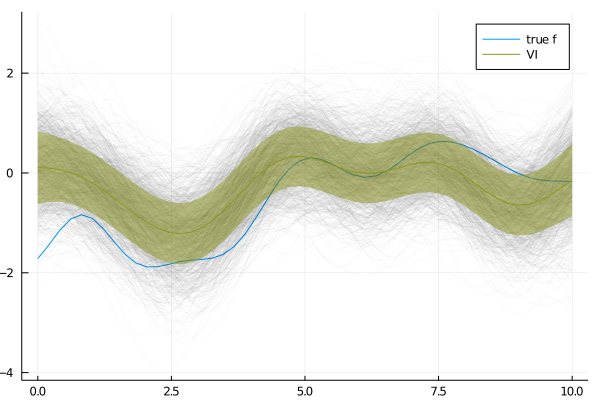

In [6]:
p1 = plot(x, f, label="true f")
plot!(x, samples, label="", color=:black, alpha=0.02, lab="")
plot!(x, mean(mfull[1]), ribbon=sqrt.(var(mfull[1])), label="VI")

### And we can also plot the predictions vs the data

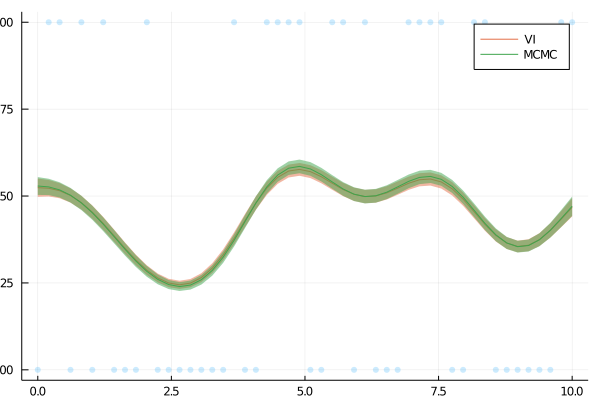

In [7]:
p2 = plot_data(x, y; size=(600,400))
μ_vi, σ_vi = proba_y(mfull, x)
plot!(x, μ_vi; ribbon=σ_vi, label="VI")
μ_mcmc, σ_mcmc = proba_y(mmcmc, x)
plot!(x, μ_mcmc; ribbon=σ_mcmc, label="MCMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*